In [1]:
from pyspark.sql.types import StringType
from pyspark import SQLContext, SparkContext
from collections import namedtuple
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, Row, ArrayType, StringType
import re
from pyspark.sql import SparkSession

import numpy as np

from pyspark.mllib.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier

from pyspark.ml.feature import  HashingTF,Tokenizer

In [2]:
spark = SparkSession \
    .builder \
    .appName("COMP 4651") \
    .getOrCreate()

In [3]:
#compute the length of song
size_ = udf(lambda xs: len(xs), IntegerType())

#filter out null song value  note: filter == where, dunno why do they create two functions...
raw_df = spark.read.json("data/lyrics.json").where((col('lyrics')).isNotNull()).filter(size_(col('lyrics')) >0)
raw_df = raw_df[raw_df.genre.isin(["Not Available", "Other"])==False]

raw_df
raw_df.show()

+---------------+-----+-----+--------------------+--------------------+----+
|         artist|genre|index|              lyrics|                song|year|
+---------------+-----+-----+--------------------+--------------------+----+
|beyonce-knowles|  Pop|    0|Oh baby, how you ...|           ego-remix|2009|
|beyonce-knowles|  Pop|    1|playin' everythin...|        then-tell-me|2009|
|beyonce-knowles|  Pop|    2|If you search
For...|             honesty|2009|
|beyonce-knowles|  Pop|    3|Oh oh oh I, oh oh...|     you-are-my-rock|2009|
|beyonce-knowles|  Pop|    4|Party the people,...|       black-culture|2009|
|beyonce-knowles|  Pop|    5|I heard
Church be...|all-i-could-do-wa...|2009|
|beyonce-knowles|  Pop|    6|This is just anot...|  once-in-a-lifetime|2009|
|beyonce-knowles|  Pop|    7|Waiting, waiting,...|             waiting|2009|
|beyonce-knowles|  Pop|    8|[Verse 1:]
I read...|           slow-love|2009|
|beyonce-knowles|  Pop|    9|N-n-now, honey
Yo...|why-don-t-you-lov...|2009|

In [4]:
sample_rf = raw_df[raw_df.year.isin(["2009", "2008", "2007", "2006"])]
sample_rf.show()

+---------------+-----+-----+--------------------+--------------------+----+
|         artist|genre|index|              lyrics|                song|year|
+---------------+-----+-----+--------------------+--------------------+----+
|beyonce-knowles|  Pop|    0|Oh baby, how you ...|           ego-remix|2009|
|beyonce-knowles|  Pop|    1|playin' everythin...|        then-tell-me|2009|
|beyonce-knowles|  Pop|    2|If you search
For...|             honesty|2009|
|beyonce-knowles|  Pop|    3|Oh oh oh I, oh oh...|     you-are-my-rock|2009|
|beyonce-knowles|  Pop|    4|Party the people,...|       black-culture|2009|
|beyonce-knowles|  Pop|    5|I heard
Church be...|all-i-could-do-wa...|2009|
|beyonce-knowles|  Pop|    6|This is just anot...|  once-in-a-lifetime|2009|
|beyonce-knowles|  Pop|    7|Waiting, waiting,...|             waiting|2009|
|beyonce-knowles|  Pop|    8|[Verse 1:]
I read...|           slow-love|2009|
|beyonce-knowles|  Pop|    9|N-n-now, honey
Yo...|why-don-t-you-lov...|2009|

In [5]:
artist_lyricses_rdd = sample_rf\
    .rdd\
    .map(lambda row: ((row[0], row[1]), row[3]))\
    .reduceByKey(lambda x,y: x+y)\

In [6]:
STOPWORDS_PATH = 'data/stopwords.txt'
stopwords = set(spark.read.text(STOPWORDS_PATH).rdd.map(lambda x: x.value).collect())
stopwords_dic = {stopword : 0 for stopword in stopwords}
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return filter(lambda token : token != "", re.split(split_regex, string.lower()))

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    return filter(lambda token : token in stopwords, simpleTokenize(string))

def tokens_to_counts (tokens):
    count_dic = stopwords_dic.copy()
    for token in tokens:
        count_dic[token] += 1
    return count_dic

In [7]:
artist_counts_rdd = artist_lyricses_rdd.map(lambda (artist, lyrics) : (artist, tokens_to_counts(tokenize(lyrics))))
artist_counts_rdd.collect()

[((u'christine-anderson', u'Rock'),
  {u'a': 80,
   u'about': 2,
   u'above': 0,
   u'after': 6,
   u'again': 9,
   u'against': 0,
   u'all': 41,
   u'am': 3,
   u'an': 7,
   u'and': 107,
   u'any': 0,
   u'are': 15,
   u'as': 13,
   u'at': 8,
   u'be': 9,
   u'because': 1,
   u'been': 10,
   u'before': 2,
   u'being': 0,
   u'below': 0,
   u'between': 0,
   u'both': 0,
   u'but': 26,
   u'by': 17,
   u'can': 33,
   u'did': 3,
   u'do': 13,
   u'does': 0,
   u'doing': 3,
   u'don': 14,
   u'down': 18,
   u'during': 0,
   u'each': 0,
   u'few': 0,
   u'for': 21,
   u'from': 7,
   u'further': 0,
   u'had': 1,
   u'has': 2,
   u'have': 14,
   u'having': 0,
   u'he': 10,
   u'her': 3,
   u'here': 10,
   u'hers': 0,
   u'herself': 0,
   u'him': 10,
   u'himself': 0,
   u'his': 3,
   u'how': 12,
   u'i': 182,
   u'if': 14,
   u'in': 66,
   u'into': 2,
   u'is': 32,
   u'it': 77,
   u'its': 5,
   u'itself': 0,
   u'just': 24,
   u'me': 61,
   u'more': 13,
   u'most': 0,
   u'my': 29,
   u'mys

In [8]:
def record_to_counts (artist_counts):
    dic = artist_counts[1]
    counts = [dic[key] for key in dic.keys()]
    return counts

In [9]:
counts_rdd = artist_counts_rdd.map(record_to_counts)
counts_rdd.collect()

[[41,
  3,
  24,
  33,
  0,
  8,
  1,
  18,
  2,
  0,
  5,
  2,
  14,
  7,
  3,
  2,
  0,
  8,
  1,
  10,
  1,
  79,
  4,
  42,
  8,
  29,
  1,
  0,
  0,
  2,
  9,
  2,
  13,
  13,
  4,
  3,
  1,
  2,
  40,
  1,
  3,
  26,
  77,
  2,
  8,
  16,
  0,
  23,
  28,
  10,
  0,
  10,
  61,
  7,
  3,
  32,
  0,
  9,
  24,
  0,
  0,
  0,
  34,
  0,
  0,
  1,
  8,
  8,
  107,
  1,
  9,
  3,
  32,
  4,
  0,
  7,
  13,
  0,
  15,
  14,
  66,
  4,
  0,
  13,
  3,
  15,
  21,
  12,
  43,
  6,
  1,
  1,
  38,
  12,
  0,
  0,
  0,
  138,
  14,
  0,
  9,
  20,
  3,
  9,
  0,
  13,
  6,
  10,
  0,
  0,
  2,
  1,
  17,
  80,
  0,
  2,
  1,
  182,
  0,
  0,
  0,
  2,
  62,
  30,
  127,
  1,
  3],
 [27,
  1,
  0,
  6,
  3,
  7,
  0,
  6,
  26,
  0,
  11,
  5,
  0,
  25,
  3,
  0,
  0,
  6,
  1,
  4,
  0,
  86,
  4,
  212,
  0,
  101,
  7,
  1,
  1,
  5,
  2,
  18,
  5,
  9,
  26,
  7,
  4,
  0,
  22,
  0,
  52,
  2,
  25,
  4,
  33,
  18,
  0,
  9,
  44,
  0,
  1,
  7,
  58,
  1,
  0,
  6,
  2,
  61,
  24

In [10]:
def rank (data):
    ranks = [0] * len(data)
    for i,x in enumerate(sorted(range(len(data)), key=lambda y: data[y])):
        ranks[x] = i
    return ranks

def discretize (data, num_of_group):
    width = len(data) / num_of_group
    if (width == 0):
        return [num_of_group - 1] * len(data)
    return map(lambda x : x / width, data)
    
def counts_to_ranks (counts):
    nonzero_counts = [c for c in counts if c > 0]
    nonzero_discretized_ranks = discretize(rank(nonzero_counts), 3)
    i = 0
    ranks = []
    for c in counts:
        if c > 0.0:
            ranks.append(nonzero_discretized_ranks[i] + 1)
            i += 1
        else:
            ranks.append(0)
    return ranks

def counts_to_occurrences (counts):
    occurrences = []
    for c in counts:
        if c > 0:
            occurrences.append(1)
        else:
            occurrences.append(0)
    return occurrences

In [11]:
ranks_rdd = counts_rdd.map(counts_to_ranks)
ranks_rdd.collect()

[[3,
  1,
  3,
  3,
  0,
  2,
  1,
  3,
  1,
  0,
  2,
  1,
  2,
  2,
  1,
  1,
  0,
  2,
  1,
  2,
  1,
  3,
  1,
  3,
  2,
  3,
  1,
  0,
  0,
  1,
  2,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  3,
  1,
  1,
  3,
  3,
  1,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  2,
  3,
  2,
  1,
  3,
  0,
  2,
  3,
  0,
  0,
  0,
  3,
  0,
  0,
  1,
  2,
  2,
  3,
  1,
  2,
  1,
  3,
  2,
  0,
  2,
  2,
  0,
  3,
  2,
  3,
  2,
  0,
  2,
  1,
  3,
  3,
  2,
  3,
  2,
  1,
  1,
  3,
  2,
  0,
  0,
  0,
  3,
  3,
  0,
  2,
  3,
  1,
  2,
  0,
  2,
  2,
  2,
  0,
  0,
  1,
  1,
  3,
  3,
  0,
  1,
  1,
  4,
  0,
  0,
  0,
  1,
  3,
  3,
  3,
  1,
  1],
 [3,
  1,
  0,
  2,
  1,
  2,
  0,
  2,
  3,
  0,
  2,
  2,
  0,
  3,
  1,
  0,
  0,
  2,
  1,
  1,
  0,
  3,
  1,
  3,
  0,
  3,
  2,
  1,
  1,
  2,
  1,
  2,
  2,
  2,
  3,
  2,
  1,
  0,
  3,
  0,
  3,
  1,
  3,
  1,
  3,
  2,
  0,
  2,
  3,
  0,
  1,
  2,
  3,
  1,
  0,
  2,
  1,
  3,
  3,
  1,
  1,
  2,
  0,
  1,
  0,
  0,
  2,
  2,
  3,
  0,
  0,
  1,
  3,

In [12]:
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

from pyspark import SparkContext
#sc =SparkContext()

In [13]:
data = ranks_rdd

# Build the model (cluster the data)
#model = KMeans.train(data, 10, maxIterations=100, initializationMode="k-means||",seed=50, initializationSteps=15, epsilon=1e-4)
model = KMeans.train(data, 5, maxIterations=200)
# Evaluate clustering by computing Within Set Sum of Squared Errors
'''
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))
'''

'\ndef error(point):\n    center = model.centers[model.predict(point)]\n    return sqrt(sum([x**2 for x in (point - center)]))\n\nWSSSE = data.map(lambda point: error(point)).reduce(lambda x, y: x + y)\nprint("Within Set Sum of Squared Error = " + str(WSSSE))\n'

In [14]:
labels = model.predict(data).collect()
labels

[4,
 4,
 4,
 4,
 1,
 1,
 2,
 0,
 1,
 1,
 3,
 2,
 3,
 2,
 2,
 3,
 4,
 0,
 2,
 4,
 4,
 1,
 4,
 4,
 1,
 1,
 4,
 1,
 4,
 0,
 1,
 4,
 2,
 4,
 0,
 4,
 1,
 2,
 1,
 1,
 1,
 4,
 3,
 4,
 2,
 2,
 4,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 3,
 2,
 1,
 2,
 3,
 1,
 3,
 2,
 3,
 4,
 2,
 4,
 1,
 4,
 4,
 0,
 3,
 1,
 3,
 1,
 2,
 3,
 1,
 4,
 1,
 2,
 4,
 4,
 1,
 0,
 4,
 1,
 4,
 0,
 4,
 2,
 1,
 2,
 4,
 4,
 1,
 2,
 3,
 0,
 2,
 3,
 4,
 1,
 2,
 4,
 1,
 2,
 2,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 3,
 4,
 2,
 4,
 3,
 1,
 3,
 1,
 1,
 1,
 4,
 3,
 4,
 4,
 0,
 1,
 0,
 4,
 1,
 1,
 1,
 1,
 2,
 3,
 4,
 2,
 1,
 0,
 0,
 1,
 0,
 4,
 1,
 2,
 4,
 4,
 4,
 4,
 1,
 4,
 0,
 4,
 4,
 1,
 1,
 1,
 1,
 2,
 4,
 2,
 3,
 1,
 4,
 3,
 1,
 1,
 0,
 3,
 3,
 0,
 3,
 4,
 2,
 3,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 3,
 1,
 0,
 4,
 4,
 2,
 3,
 1,
 3,
 3,
 0,
 1,
 1,
 1,
 4,
 2,
 3,
 4,
 4,
 2,
 4,
 3,
 3,
 0,
 1,
 3,
 4,
 4,
 3,
 4,
 4,
 0,
 1,
 4,
 1,
 4,
 1,
 4,
 4,
 2,
 3,
 2,
 2,
 3,
 1,
 0,
 3,
 2,
 4,
 1,
 4,
 3,
 3,
 0,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 4,


In [15]:
artists = artist_counts_rdd.map(lambda record : record[0]).collect()
artists

[(u'christine-anderson', u'Rock'),
 (u'aeternus', u'Metal'),
 (u'chris-walla', u'Rock'),
 (u'barlowgirl', u'Rock'),
 (u'city-and-colour', u'Indie'),
 (u'blanks-77', u'Rock'),
 (u'brad-caleb-kane', u'Pop'),
 (u'faf-larage', u'Hip-Hop'),
 (u'cranberries', u'Rock'),
 (u'estelle', u'Hip-Hop'),
 (u'connie-talbot', u'Pop'),
 (u'emilie-simon', u'Electronic'),
 (u'digital-summer', u'Rock'),
 (u'amy-can-flyy', u'Pop'),
 (u'alexander', u'Pop'),
 (u'ann-hampton-callaway', u'Jazz'),
 (u'coroner', u'Metal'),
 (u'doidivanas', u'Rock'),
 (u'control-machete', u'Hip-Hop'),
 (u'emmet-swimming', u'Rock'),
 (u'cindy-alexander', u'Rock'),
 (u'faction', u'Rock'),
 (u'alexander-oneal', u'Electronic'),
 (u'cadacross', u'Metal'),
 (u'clay-aiken', u'Pop'),
 (u'confederate-railroad', u'Rock'),
 (u'chic', u'Electronic'),
 (u'david-allan-coe', u'Country'),
 (u'destiny', u'Metal'),
 (u'gita-gutawa', u'Metal'),
 (u'franz-ferdinand', u'Rock'),
 (u'airlock', u'Electronic'),
 (u'aa', u'Rock'),
 (u'dirt-poor-robins', u'

In [16]:
import pandas as pd

clusters = pd.DataFrame(artists)
clusters.columns = ['artist', 'genre']
clusters['cluster'] = labels
genres = list(clusters.genre.unique())
genreCode = map(lambda genre : genres.index(genre), clusters.genre)
clusters['genreCode'] = genreCode

In [17]:
clusters

artist       genre  cluster  genreCode
0       christine-anderson        Rock        4          0
1                 aeternus       Metal        4          1
2              chris-walla        Rock        4          0
3               barlowgirl        Rock        4          0
4          city-and-colour       Indie        1          2
5                blanks-77        Rock        1          0
6          brad-caleb-kane         Pop        2          3
7               faf-larage     Hip-Hop        0          4
8              cranberries        Rock        1          0
9                  estelle     Hip-Hop        1          4
10           connie-talbot         Pop        3          3
11            emilie-simon  Electronic        2          5
12          digital-summer        Rock        3          0
13            amy-can-flyy         Pop        2          3
14               alexander         Pop        2          3
15    ann-hampton-callaway        Jazz        3          6
16                 coroner       Metal        4          1
17              doidivanas        Rock        0          0
18         control-machete     Hip-Hop        2          4
19          emmet-swimming        Rock        4          0
20         cindy-alexander        Rock        4          0
21                 faction        Rock        1          0
22         alexander-oneal  Electronic        4          5
23               cadacross       Metal        4          1
24              clay-aiken         Pop        1          3
25    confederate-railroad        Rock        1          0
26                    chic  Electronic        4          5
27         david-allan-coe     Country        1          7
28                 destiny       Metal        4          1
29             gita-gutawa       Metal        0          1
...                    ...         ...      ...        ...
5279           chris-isaak        Rock        1          0
5280        george-clinton        Jazz        4          6
5281         anthony-smith     Country        3          7
5282             bluemchen  Electronic        0          5
5283                 craft       Metal        2          1
5284     the-bicycle-thief        Rock        3          0
5285                fergie         Pop        1          3
5286               ashanti         Pop        1          3
5287  dogs-die-in-hot-cars        Rock        4          0
5288          flying-blind        Rock        4          0
5289            adam-green        Rock        1          0
5290        chad-vangaalen        Rock        4          0
5291               bracket        Rock        1          0
5292                  amil     Hip-Hop        1          4
5293          duncan-sheik        Rock        1          0
5294                fisher        Rock        1          0
5295             black-box  Electronic        4          5
5296            david-ball     Country        1          7
5297             galadriel       Metal        4          1
5298                cramps        Rock        4          0
5299            antimatter        Rock        4          0
5300           erykah-badu        Jazz        1          6
5301                 cynic       Metal        4          1
5302        emily-bindiger        Jazz        2          6
5303               devlins        Rock        4          0
5304          cheeky-girls       Metal        3          1
5305              2contra1        Rock        0          0
5306          evidence-one        Rock        3          0
5307            cancerslug        Rock        1          0
5308           avery-storm     Hip-Hop        3          4

[5309 rows x 4 columns]

In [18]:
assessment = pd.DataFrame(clusters.groupby(['cluster', 'genreCode'])['artist'].count())
assessment.reset_index(inplace=True)
assessment

cluster  genreCode  artist
0         0          0     165
1         0          1      21
2         0          2       2
3         0          3     116
4         0          4      38
5         0          5      26
6         0          6      14
7         0          7       1
8         0          8       1
9         0          9      15
10        1          0     817
11        1          1     195
12        1          2      18
13        1          3     229
14        1          4     200
15        1          5      27
16        1          6      28
17        1          7     106
18        1          8      20
19        1          9      15
20        2          0     298
21        2          1      52
22        2          2       9
23        2          3     180
24        2          4      61
25        2          5     100
26        2          6      40
27        2          7      24
28        2          8      14
29        2          9      15
30        3          0     396
31        3          1     120
32        3          2      16
33        3          3     142
34        3          4      89
35        3          5      74
36        3          6      41
37        3          7      31
38        3          8      19
39        3          9      13
40        4          0     723
41        4          1     264
42        4          2      25
43        4          3     240
44        4          4      76
45        4          5      73
46        4          6      37
47        4          7      49
48        4          8      16
49        4          9      18

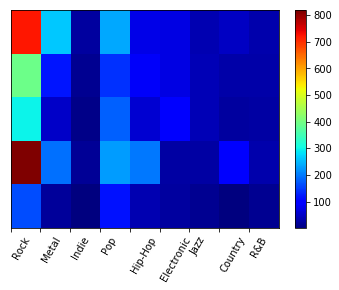

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x = clusters.genreCode
y = clusters.cluster+1

plt.subplots()
xlabels = genres
plt.xticks(range(max(x)), xlabels, rotation=60, ha='left')
plt.yticks([],ha='right')

plt.hist2d(x, y, (max(x), max(y)), cmap=plt.cm.jet)

plt.colorbar()
plt.show()